In [54]:
using POMDPs
using StaticArrays
using LinearAlgebra
using Random
using POMDPModelTools
using Plots
using Distributions: Normal, logpdf
using Flux
using Flux: params, gradient, update!
# using ElectronDisplay

In [55]:
# State of a Drone.
struct DroneState <: FieldVector{4, Float32}
    x::Float32 # x location in meters
    y::Float32 # y location in meters
    theta::Float32 # orientation in radian
    status::Int64 # indicator whether robot has reached goal state or crashed
end

# state-space definitions
struct ContinuousDroneStateSpace end
Base.eltype(sspace::Type{ContinuousDroneStateSpace}) = DroneState


In [56]:
# Struct for a Drone action
struct DroneAct <: FieldVector{2, Float32}
    v::Float32     # meters per second
    omega::Float32 # theta dot (rad/s)
end

# action spaces
struct DroneActions end


In [57]:
# Obstacle and Target area Struct
struct Circle
    x::Float32 # x location in meters
    y::Float32 # y location in meters
    r::Float32 # radius in meters
end

In [58]:

struct Env
    goal::Circle
    obstacles::Vector{Circle}
end

In [59]:
# generate random obstacles
function generate_obstacles(size::SVector{2, SVector{2, Float32}}, num_obstacles::Int64, goal::Circle)
    obstacles = Vector{Circle}()
    min_radius= 2.5
    max_radius = 7.5
    for _ in 1:num_obstacles
        obstacle_x, obstacle_y = rand(size[1][1]:size[1][2]), rand(size[2][1]:size[2][2])
        obstacle_r = rand(min_radius:max_radius)

        ## if target and obstacle regions overlap, generate new obstacle
        while norm([goal.x, goal.y].- [obstacle_x, obstacle_y]) < goal.r + obstacle_r
            obstacle_x, obstacle_y = rand(size[1][1]:size[1][2]), rand(size[2][1]:size[2][2])
            obstacle_r = rand(min_radius:max_radius)
        end
        obstacle = Circle(obstacle_x, obstacle_y, obstacle_r)
        push!(obstacles, obstacle)
    end
    return obstacles
end;

In [60]:
# Define the Drone MDP.
mutable struct DroneMDP <: MDP{DroneState, DroneAct}
    v_max::Float32 # maximum velocity of Drone [m/s]
    om_max::Float32 # maximum turn-rate of Drone [rad/s]
    dt::Float32 # simulation time-step [s]
    pen::Float32 # penalty for crash or out of bounds
    time_pen::Float32 # penalty per time-step
    goal_reward::Float32 # reward for reaching goal
    discount::Float32
    size::SVector{2, SVector{2, Float32}}
    sspace::ContinuousDroneStateSpace
    num_obstacles::Int64
    goal::Circle
    env::Env
    aspace::DroneActions
end

function DroneMDP(;
            v_max=2.0, 
            om_max=1.0, 
            dt=0.5, 
            pen=-1000.0, 
            time_pen=-1.0, 
            goal_reward=100.0,
            discount=0.95,
            size=SVector(SVector(Float32(0.0), Float32(50.0)), SVector(Float32(0.0),Float32( 50.0))),
            sspace=ContinuousDroneStateSpace(),
            num_obstacles=10, 
            aspace=DroneActions())
            Random.seed!(1)
            goal= Circle(rand(size[1][1]:size[1][2]), rand(size[2][1]:size[2][2]), 5.0)
            env = Env(goal,generate_obstacles(size,num_obstacles,goal))
        return DroneMDP(v_max,om_max,dt,pen,time_pen,goal_reward,discount,
                        size,sspace,num_obstacles,goal,env,aspace)
end;

In [61]:
const DroneModel = Union{DroneMDP};

In [62]:
# access the mdp of a DroneModel
mdp(e::DroneMDP) = e;

In [63]:
# access the Enviroment of a DroneModel
env(m::DroneMDP) = m.env;

In [64]:
# access the state space of a DroneModel
sspace(m::DroneMDP) = m.sspace;

In [65]:
POMDPs.actions(m::DroneModel) = mdp(m).aspace
n_actions(m::DroneModel) = length(mdp(m).aspace);

In [66]:
# transition Drone state given curent state and action
POMDPs.transition(m::DroneMDP, s::DroneState, a::DroneAct) = get_next_state(m, s, a)

In [67]:
# terminal condition handling
function terminal(m::DroneMDP,x,y)
    distance_to_target = norm([x, y].- [m.env.goal.x, m.env.goal.y])
    if distance_to_target <= m.env.goal.r
        return 1
    end

    for i in 1:length(m.env.obstacles)
        distance_to_obstacle = norm([x, y].- [m.env.obstacles[i].x, m.env.obstacles[i].y])
        if distance_to_obstacle <= m.env.obstacles[i].r
            return -1
        end
    end

    # check for out of bounds
    if x >= m.size[1][2] || x <= m.size[1][1] || y >= m.size[2][2] || y <= m.size[2][1]
        return -1
    end

    return 0
end;

In [68]:
function get_next_state(m::DroneMDP, s::DroneState, a::DroneAct)
    v, om = a
    v = clamp(v, -m.v_max, m.v_max)
    om = clamp(om, -m.om_max, m.om_max)

    x, y, th, status = s
    dt = m.dt

    # dynamics assume drone rotates and then translates
    next_th = mod( th + om*dt,2*pi)

    # make sure we arent going through a wall
    p0 = SVector(x, y)
    heading = SVector(cos(next_th), sin(next_th))
    des_step = v*dt
    pos = p0 + des_step*heading

    # Determine whether reached goal, obstacle or out of bounds
    next_status =  terminal(m,pos[1],pos[2])
        
    

    # define next state
    return DroneState(pos[1], pos[2], next_th, next_status)
end;

In [69]:
# enumerate all possible states in a DiscreteDroneStateSpace
POMDPs.states(m::DroneModel) = sspace(m)


In [70]:
# defines reward function R(s,a,s')
function POMDPs.reward(m::DroneModel,s::DroneState, a::DroneAct,sp::DroneState)
    
    # penalty for each timestep elapsed
    cum_reward = mdp(m).time_pen

    # terminal rewards
    cum_reward += mdp(m).goal_reward*(sp.status == 1)
    cum_reward += mdp(m).pen*(sp.status == -1)

    return cum_reward  
end

In [71]:
# determine if a terminal state has been reached
POMDPs.isterminal(m::DroneModel, s::DroneState) = abs(s.status) > 0.0

In [72]:
# define discount factor
POMDPs.discount(m::DroneModel) = mdp(m).discount

In [73]:
# struct to define an initial distribution over Drone states
struct DroneInitialDistribution{M<:DroneModel}
    m::M
end

# definition of initialstate for Drone environment
POMDPs.initialstate(m::DroneModel) = DroneInitialDistribution(m)

In [74]:
function Base.rand(rng::AbstractRNG, d::DroneInitialDistribution)
    x, y = init_pos(mdp(d.m).room, rng)
    th = rand(rng) * 2*pi - pi
    return RoombaState(x, y, th, 0.0)
end;

In [75]:
# generate next state sp, and reward r 
function POMDPs.gen(m::DroneMDP,s::DroneState, action::DroneAct)
    sp = transition(m,s, action)
    r = reward(m,s,action,sp)

    return sp, r
end;

In [76]:
#Generate points for the circle
function plot_circle(x, y, r, fill_color=:none)
    theta = LinRange(0, 2π, 100)  # Angle range from 0 to 2π
    circle_x = x .+ r * cos.(theta)
    circle_y = y .+ r * sin.(theta)
    return plot!(circle_x, circle_y, aspect_ratio=1, legend=false, fillalpha=0.7, fillopacity=0.7, fill=true, fillcolor=fill_color)
end

##Render MDP 
function render(m::DroneMDP,s=DroneState(0.0, 0.0, 0.0, 0.0); show=true, t=nothing)
    p = plot(size=(600, 600), xlim=(m.size[1][1]-2, m.size[1][2]+2), ylim=(m.size[2][1]-2, m.size[2][2]+2), legend=false)
    xticks!(0:5:m.size[1][2]+1)
    yticks!(0:5:m.size[2][2]+1)
    for (i, obs) in enumerate(m.env.obstacles)
        plot_circle(obs.x, obs.y, obs.r,:red)
    end
    plot_circle(m.env.goal.x, m.env.goal.y, m.env.goal.r,:green)
    quiver!([s[1]], [s[2]], quiver=[(1*cos(s[3]), 1*sin(s[3]))], color=:blue, arrow=true, linewidth=2)
    
    plot!([m.size[1][1]+0.5, m.size[2][1]+0.5], [m.size[1][1]+0.5, m.size[2][2]+0.5], color=:black, linewidth=2)
    plot!([m.size[1][1]+0.5, m.size[2][2]+0.5], [m.size[1][1]+0.5, m.size[2][1]+0.5], color=:black, linewidth=2)
    plot!([m.size[1][1]+0.5, m.size[2][2]+0.5], [m.size[1][2]+0.5, m.size[2][2]+0.5], color=:black, linewidth=2)
    plot!([m.size[1][2]+0.5, m.size[2][2]+0.5], [m.size[1][2]+0.5, m.size[2][1]+0.5], color=:black, linewidth=2)
    if !isnothing(t)
        annotate!(m.size[1][2]/2, m.size[2][2]-2, text("t=$t", :center, 12))
    end

    if show
        display(p)
    end
end;

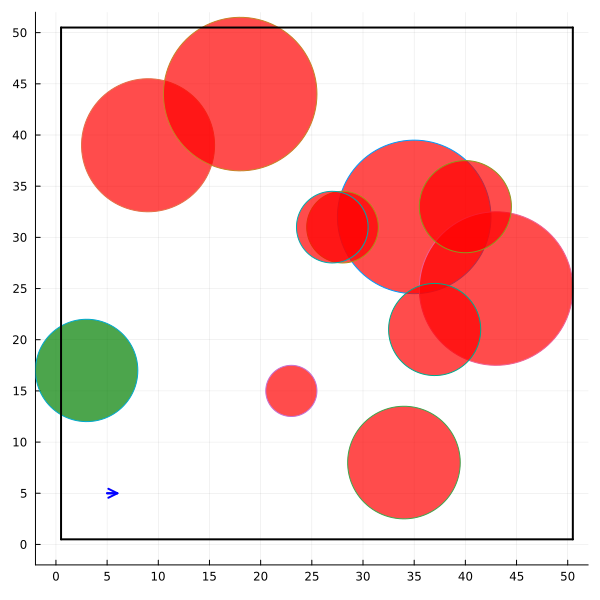

In [77]:
m = DroneMDP()
s = DroneState(5,5,0.0,false)
re =0.0
render(m,s)

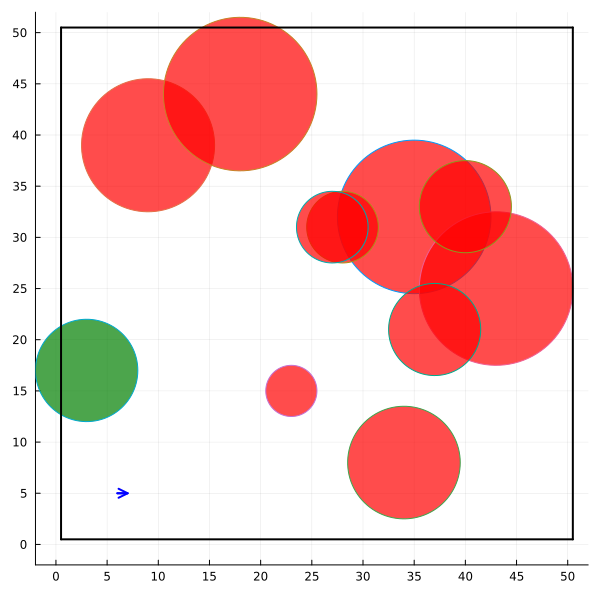

(sp, r) = gen(m, s, a) = (Float32[6.0, 5.0, 0.0, 0], -1.0f0)
re += r = -1.0


In [78]:

a = DroneAct(4,0)
@show sp, r = gen(m,s,a)
@show re += r
s = sp
render(m,s)

In [79]:

struct ActorCritic
    actor::Chain
    critic::Chain
end

function ActorCritic(state_size::Int, action_size::Int)
    actor = Chain(
        Dense(state_size, 64, sigmoid),
        Dense(64, action_size * 2),
        x -> [x[1],x[2], softplus.(x[3]),softplus.(x[4])]
    )

    critic = Chain(
        Dense(state_size, 64, sigmoid),
        Dense(64, 1)
    )

    return ActorCritic(actor, critic)
end

ActorCritic

In [80]:
function forward(ac::ActorCritic, state::DroneState)
    actor_out = ac.actor(state)
    action_mean = [actor_out[1], actor_out[2]]
    action_std = [actor_out[3], actor_out[4]]  
    value = ac.critic(state)[1]
    return [action_mean, action_std], value  # Concatenate means and std deviations into a single array
end

forward (generic function with 1 method)

In [82]:
function log_prob(ac::ActorCritic, states::Vector{DroneState}, actions::Vector{DroneAct})
    log_probs = zeros(length(states))

    for i in 1:length(states)
        (action_mean, action_std), _ = forward(ac, states[i])
        log_probs[i] = sum(logpdf.(Normal.(action_mean, action_std), actions[i]))
    end

    return log_probs
end


log_prob (generic function with 1 method)

In [83]:
function simulation(m::DroneMDP, s0::DroneState, max_steps=Inf)
    t = 0
    s = s0
    states::Vector{DroneState} = []
    actions::Vector{DroneAct} = []
    rewards = []
    values = []
    while !isterminal(m, s) && t < max_steps
        (action_mean, action_std), value = forward(ac, s0)
        push!(values,value)
        a = DroneAct(rand.(Normal.(action_mean, action_std)))  # Call the policy_function
        push!(actions,a)
        s, r = gen(m,s,a)
        push!(states,s)
        push!(rewards,r)
        
        t += 1
    end
    
    return states,actions,rewards,values  
end;

In [84]:

function compute_advantage(r::Vector, values::Vector, discount::Float32, lambda::Float32)
    T = length(r)
    δ = r .+ discount * [values[2:end]; 0] .- values
    advantages = similar(δ)
    running_advantage = 0
    for t in T:-1:1
        running_advantage = δ[t] + discount * lambda * running_advantage
        advantages[t] = running_advantage
    end
    return advantages
end

compute_advantage (generic function with 1 method)

In [85]:
function ppo_loss(ac::ActorCritic, states, actions, rewards, values, discount, lambda, eps_clip)

    # Compute advantages
    advantages = compute_advantage(rewards, values, discount, lambda)

    # Compute old and new log probabilities
    old_log_probs = log_prob(ac, states, actions)
    new_log_probs = log_prob(ac, states, actions)

    # Compute ratio and clipped ratio
    ratio = exp.(new_log_probs - old_log_probs)
    clipped_ratio = clamp.(ratio, 1 - eps_clip, 1 + eps_clip)

    # Compute surrogate loss
    surrogate_loss = min.(advantages .* ratio, advantages .* clipped_ratio)

    # Compute value loss
    value_loss = sum((rewards .+ discount * [values[2:end]; 0] .- values).^2)

    # Compute total loss
    loss = -mean(surrogate_loss) + 0.5 * value_loss

    return loss
end

ppo_loss (generic function with 1 method)

In [123]:
m = DroneMDP()
ac = ActorCritic(4,2)
s0 = DroneState(5,5,0.0,false)
states1, actions1, rewards1, values1  =  simulation(m,s0,1000)
lambda = Float32(0.99)
eps_clip = Float32(0.2);